# Лабораторная работа 4
1) Реализовать решение СЛАУ двумя итерационными методами:
- простой итерации;
- Зейделя.
2) Сравнить количество итераций \
Находить решения с разной точностью, проверить, есть ли зависимость между $\epsilon$ и количеством итераций *k*.
3) Протестировать работу методов на плохо обусловленных матрицах

In [273]:
import seaborn as sns
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from scipy.linalg import hilbert
import unittest
from parameterized import parameterized, parameterized_class
from tabulate import tabulate
import numpy.testing

def run_test(TestCase):
    test_runner = unittest.TextTestRunner(verbosity=2)
    test_runner.run(unittest.makeSuite(TestCase))

## Метод простой итерации

In [274]:
def error(x1, x2):
    return np.linalg.norm(x1 - x2)

def posteriori_error(x1, x2, B):
    B_norm = np.linalg.norm(B, ord=2)
    return B_norm / (1 - B_norm) * error(x1, x2)

def transform(A, b):
    N = A.shape[0]
    B = np.zeros((N, N))
    C = np.zeros((N, 1))
    for i in range(N):
        C[i] = b[i] / A[i, i]
        for j in range(N):
            B[i, j] = 0 if i == j else -A[i, j] / A[i, i]

    return B, C

def transform_pos_definititve(A, b):
    N = A.shape[0]
    m = min(A[k, k] - sum(abs(A[k, j]) if k != j else 0 for j in range(N)) for k in range(N))
    m = max(m, 0)
    M = max(A[k, k] + sum(abs(A[k, j]) if k != j else 0 for j in range(N)) for k in range(N))
    alpha = 2 / (m + M)
    B = np.identity(N) - alpha * A
    C = alpha * b
    return B, C

def iterative(A, b, E, get_iterations = False, pos_definitive=False, max_iter=100000):
    N = A.shape[0]
    if pos_definitive:
        B, C = transform_pos_definititve(A, b)
    else:
        B, C = transform(A, b)

    p = max(abs(np.linalg.eigvals(B)))
    if p >= 1:
        raise ValueError(f'p(B) == {p} >= 1, метод простой итерации не сходится')

    x = C
    i = 0
    while i < max_iter:
        i += 1
        x_next = B @ x + C
        if posteriori_error(x_next, x, B) < E:
            break
        x = x_next

    if get_iterations:
        return x_next, i
    else:
        return x_next

In [275]:
def test_name(testcase_func, param_num, param):
    size = str(param.args[0])
    eps = str(param.args[1])
    return "%s_%s" %(
        testcase_func.__name__,
        parameterized.to_safe_name(f'_{size}x{size}_eps={eps}')
    )

def gen_diagonally_dominant(size):
        A = numpy.random.rand(size, size)
        for i in range(size):
            A[i, i] = sum([abs(A[i, j]) for j in range(size)]) + 1
        return A

class IterativeTestCase(unittest.TestCase):
    @parameterized.expand([(i, 10 ** -eps) for i, eps in product(range(2, 15), range(1, 12))], name_func=test_name)
    def test_iterative(self, size, eps):
        A = gen_diagonally_dominant(size)
        x = np.ones((size, 1))
        b = A @ x
        actual = iterative(A, b, eps)
        np.testing.assert_allclose(x, actual, rtol=eps)

    @parameterized.expand([(i, 10 ** -eps) for i, eps in product(range(2, 5), range(1, 8))], name_func=test_name)
    def test_hilbert(self, size, eps):
        A = hilbert(size)
        x = np.ones((size, 1))
        b = A @ x
        actual = iterative(A, b, eps, pos_definitive=True)
        np.testing.assert_allclose(x, actual, rtol=eps)

        #self.assertRaises(ValueError, iterative, A, b, eps) # На матрице гильберта не сходится


run_test(IterativeTestCase)

test_hilbert__2x2_eps_0_0001 (__main__.IterativeTestCase) ... ok
test_hilbert__2x2_eps_0_001 (__main__.IterativeTestCase) ... ok
test_hilbert__2x2_eps_0_01 (__main__.IterativeTestCase) ... ok
test_hilbert__2x2_eps_0_1 (__main__.IterativeTestCase) ... ok
test_hilbert__2x2_eps_1e_05 (__main__.IterativeTestCase) ... ok
test_hilbert__2x2_eps_1e_06 (__main__.IterativeTestCase) ... ok
test_hilbert__2x2_eps_1e_07 (__main__.IterativeTestCase) ... ok
test_hilbert__3x3_eps_0_0001 (__main__.IterativeTestCase) ... ok
test_hilbert__3x3_eps_0_001 (__main__.IterativeTestCase) ... ok
test_hilbert__3x3_eps_0_01 (__main__.IterativeTestCase) ... ok
test_hilbert__3x3_eps_0_1 (__main__.IterativeTestCase) ... ok
test_hilbert__3x3_eps_1e_05 (__main__.IterativeTestCase) ... ok
test_hilbert__3x3_eps_1e_06 (__main__.IterativeTestCase) ... ok
test_hilbert__3x3_eps_1e_07 (__main__.IterativeTestCase) ... ok
test_hilbert__4x4_eps_0_0001 (__main__.IterativeTestCase) ... ok
test_hilbert__4x4_eps_0_001 (__main__.Itera

## Метод Зейделя

In [276]:
def seidel(A, b, E, get_iterations = False, max_iter=100000):
    N = A.shape[0]
    B, C = transform(A, b)

    x = np.zeros((N, 1))

    k = 0
    while k < max_iter:
        k += 1
        x_next = np.copy(x)
        for i in range(N):
            x_next[i] = sum(B[i, j] * x_next[j] for j in range(i)) + sum(B[i, j] * x[j] for j in range(i + 1, N)) + C[i]
        if np.linalg.norm(x - x_next) < E / (10 ** N):
            break
        x = x_next

    if get_iterations:
        return x_next, k
    else:
        return x_next

In [277]:
class SeidelTestCase(unittest.TestCase):
    @parameterized.expand([(i, 10 ** -eps) for i, eps in product(range(2, 5), range(1, 12))], name_func=test_name)
    def test_seidel(self, size, eps):
        A = hilbert(size)
        x = np.ones((size, 1))
        b = A @ x
        actual = seidel(A, b, eps)
        np.testing.assert_allclose(x, actual, rtol=eps)

run_test(SeidelTestCase)

test_seidel__2x2_eps_0_0001 (__main__.SeidelTestCase) ... ok
test_seidel__2x2_eps_0_001 (__main__.SeidelTestCase) ... ok
test_seidel__2x2_eps_0_01 (__main__.SeidelTestCase) ... ok
test_seidel__2x2_eps_0_1 (__main__.SeidelTestCase) ... ok
test_seidel__2x2_eps_1e_05 (__main__.SeidelTestCase) ... ok
test_seidel__2x2_eps_1e_06 (__main__.SeidelTestCase) ... ok
test_seidel__2x2_eps_1e_07 (__main__.SeidelTestCase) ... ok
test_seidel__2x2_eps_1e_08 (__main__.SeidelTestCase) ... ok
test_seidel__2x2_eps_1e_09 (__main__.SeidelTestCase) ... ok
test_seidel__2x2_eps_1e_10 (__main__.SeidelTestCase) ... ok
test_seidel__2x2_eps_1e_11 (__main__.SeidelTestCase) ... ok
test_seidel__3x3_eps_0_0001 (__main__.SeidelTestCase) ... ok
test_seidel__3x3_eps_0_001 (__main__.SeidelTestCase) ... ok
test_seidel__3x3_eps_0_01 (__main__.SeidelTestCase) ... ok
test_seidel__3x3_eps_0_1 (__main__.SeidelTestCase) ... ok
test_seidel__3x3_eps_1e_05 (__main__.SeidelTestCase) ... ok
test_seidel__3x3_eps_1e_06 (__main__.SeidelT

## Зависимость между $\epsilon$ и количеством итераций

In [278]:
plt.style.use('default')
sns.color_palette('bright')

def plot(data, title, xticks):
    df = pd.DataFrame(data, index=xticks)

    plt.figure(figsize=(15, 10), dpi=80)

    for key in df.keys():
        plt.plot(df[key], label=key, marker='o')

    plt.title(title)
    plt.legend(title='Размерность матрицы')
    plt.xlabel('Епсилон', fontsize=20)
    plt.ylabel('Количество итераций', fontsize=20)
    plt.xscale('log')
    plt.show()

### Метод простой итерации

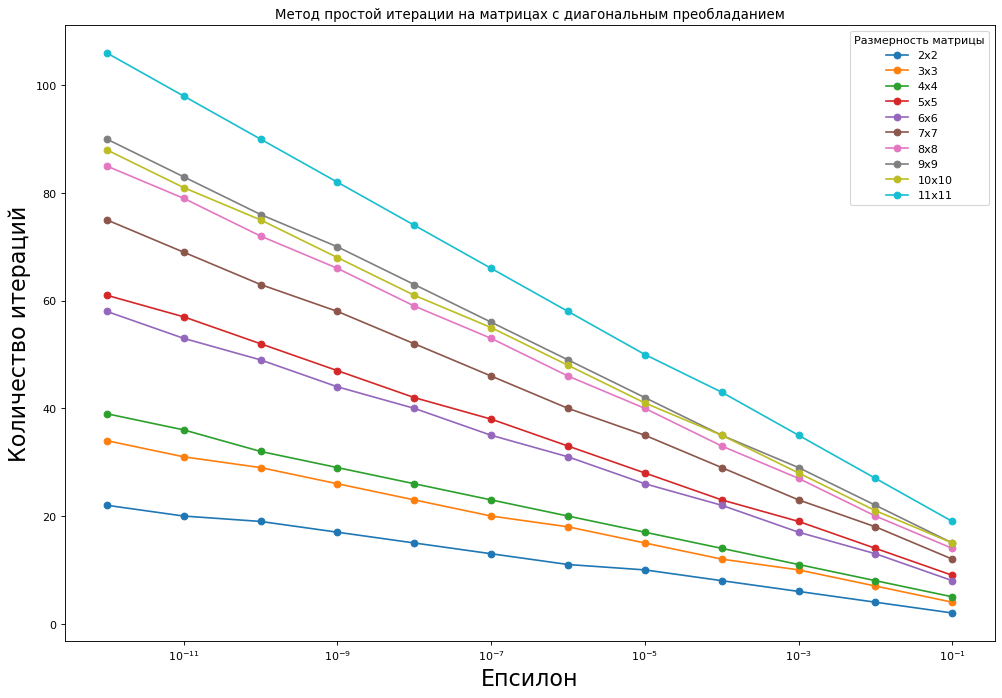

In [279]:
data = {}
for size in range(2, 12):
    key = f'{size}x{size}'
    data[key] = []
    A = gen_diagonally_dominant(size)
    x = np.ones((size, 1))
    b = A @ x

    for eps in range(1, 13):
        actual, k = iterative(A, b, 10 ** -eps, True)
        data[key].append(k)

plot(data, 'Метод простой итерации на матрицах с диагональным преобладанием', [10 ** -p for p in range(1, 13)])

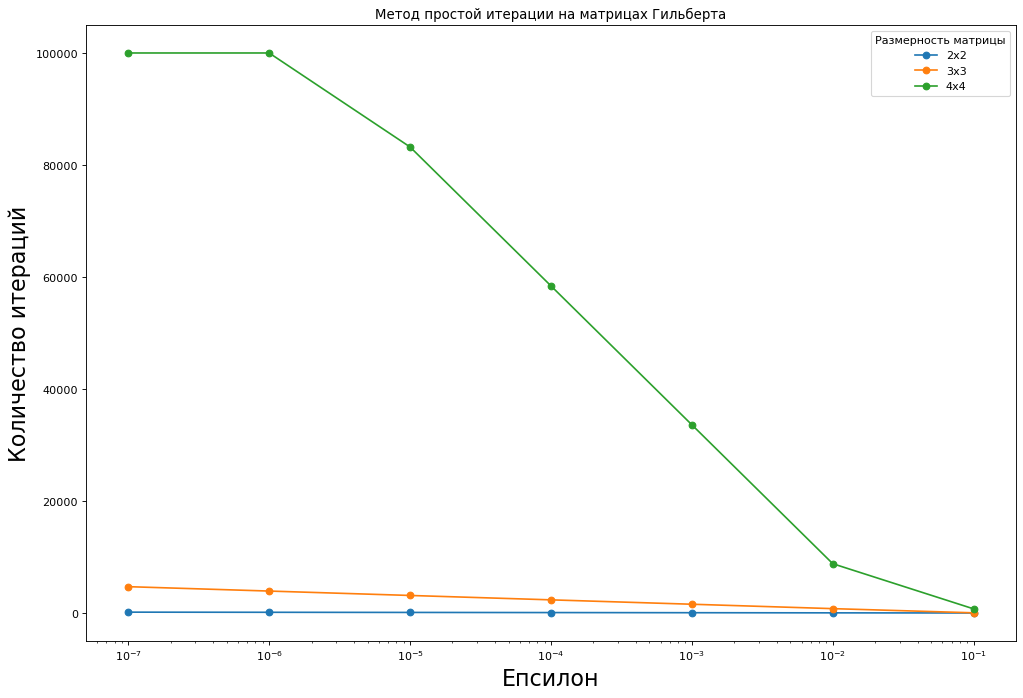

In [280]:
data = {}
for size in range(2, 5):
    key = f'{size}x{size}'
    data[key] = []
    A = hilbert(size)
    x = np.ones((size, 1))
    b = A @ x

    for eps in range(1, 8):
        actual, k = iterative(A, b, 10 ** -eps, get_iterations=True, pos_definitive=True)
        data[key].append(k)

plot(data, 'Метод простой итерации на матрицах Гильберта', [10 ** -p for p in range(1, 8)])

### Метод Зейделя

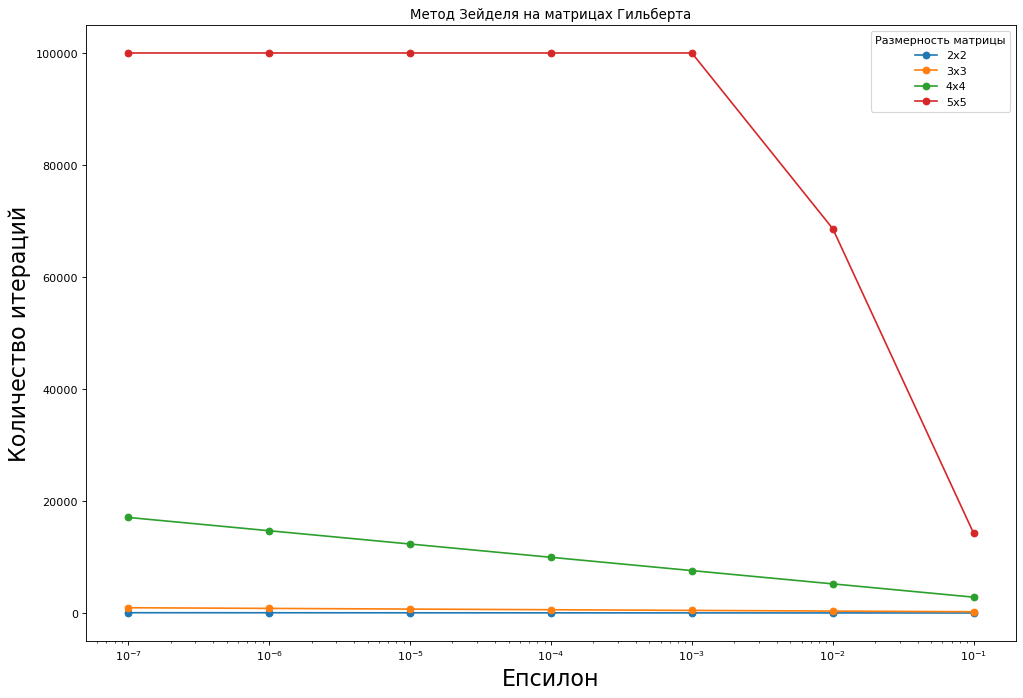

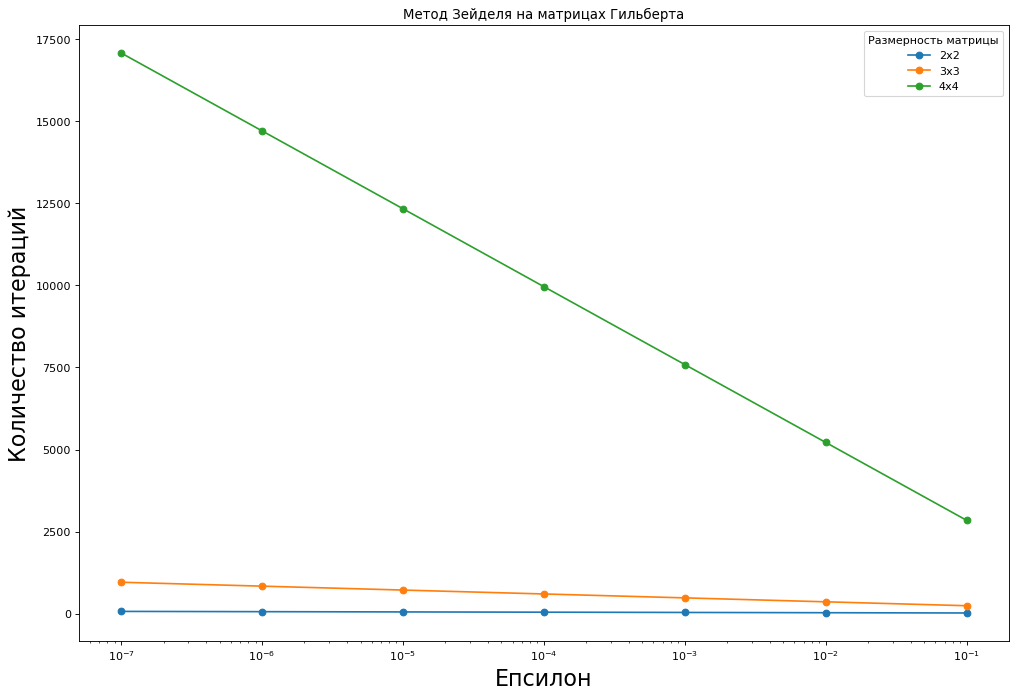

In [281]:
def plot_seidel(rsize):
    data = {}
    for size in range(2, rsize):
        key = f'{size}x{size}'
        data[key] = []
        A = hilbert(size)
        x = np.ones((size, 1))
        b = A @ x

        for eps in range(1, 8):
            actual, k = seidel(A, b, 10 ** -eps, True)
            data[key].append(k)

    plot(data, 'Метод Зейделя на матрицах Гильберта', [10 ** -p for p in range(1, 8)])

plot_seidel(6)
plot_seidel(5)

### Метод простой итерации на плохо обусловленных матрицах (Гильберта)

In [282]:
def iterative_test_hilbert(size, eps):
    H = hilbert(size)
    x = np.ones((size, 1))
    b = H @ x
    try:
        actual, iters = iterative(H, b, eps, get_iterations=True, pos_definitive=True)
    except ValueError:
        print(f'Метод простой итерации не сходится на матрице Гильберта {size}x{size}')
        return

    if iters == 100000:
        print(f'Превышено максимальное количество итераций=100000 для матрицы Гильберта {size}x{size} с погрешностью eps={eps}')
        return

    print(f'Для матрицы гильберта {size}x{size} найдено решение с погрешностью eps={eps}')

iterative_test_hilbert(2, 1e-10)
iterative_test_hilbert(3, 1e-8)
iterative_test_hilbert(6, 1e-8)


Для матрицы гильберта 2x2 найдено решение с погрешностью eps=1e-10
Для матрицы гильберта 3x3 найдено решение с погрешностью eps=1e-08
Превышено максимальное количество итераций=100000 для матрицы Гильберта 6x6 с погрешностью eps=1e-08
